In [41]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor,sqrt

In [2]:
def hog_descriptor(img):
    hog = cv2.HOGDescriptor()
    h = hog.compute(img)
    return h

In [3]:
def videoReader(video,play=False):
    cap = cv2.VideoCapture(video)
    if (cap.isOpened() == False): 
        print("Error opening video stream or file")
    if play:
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                cv2.imshow('Frame',frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()
        cv2.destroyAllWindows()
    return cap

In [4]:
def match_video(image_descriptor, path_video, width, height):
    samples_per_video = 5
    
    video = videoReader(path_video)
    numberOfFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video_width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print("Video info", path_video,"Frames",numberOfFrames,"Dimensions",video_width,video_height,"Distance ",end='')
    
    min_distance = 100000
    
    for i in range(0,numberOfFrames,numberOfFrames//samples_per_video):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        res, frame = video.read()
#         print(frame.shape)
        resized_frame = cv2.resize(frame,(width,height),cv2.INTER_CUBIC)
#         print(resized_frame.shape)
        frame_descriptor = hog_descriptor(resized_frame)
        
        distance = np.linalg.norm(frame_descriptor - image_descriptor)
#         print(distance)
        if min_distance > distance:
            min_distance = distance
#             min_index = i
    print(min_distance)
    return min_distance

# Read image

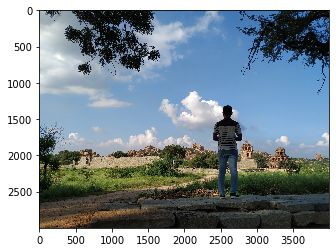

In [5]:
img = cv2.imread('./input_images/yash.jpg')
plt.imshow(img[:,:,::-1])
img = img[:,:,::-1]

In [6]:
# cap = videoReader(video_path)
# numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# print(numberOfFrames,width,height)

In [7]:
from os import listdir
from os.path import isfile, join
videos_dir = '../videos_h264/'
videos_paths = [videos_dir + f for f in listdir(videos_dir) if isfile(join(videos_dir, f))]
print(len(videos_paths))

463


In [8]:
# plt.figure(figsize=(16,16))
# plt.subplot(1,2,1)
# plt.imshow(im)
# plt.subplot(1,2,2)
# plt.imshow(h)

In [1]:
print(time.time())

resized_image = cv2.resize(img,(256,128),cv2.INTER_CUBIC)
image_descriptor = hog_descriptor(resized_image)

min_index = None
min_distance = 100000
count = 0
total = len(videos_paths)
for video_path in videos_paths:
    if video_path == '../videos_h264/Thumbs.db':
        continue
    distance = match_video(image_descriptor, video_path,256,128)
    if distance < min_distance:
        min_distance = distance
        min_index = video_path
    count += 1
    if count % 25:
        print(count,'/',total)
print(min_distance)
print(min_index)
print(time.time())

### Time taken in mintues - 12.85

#  Method 2

# Reduced Dimentional HOG Features

In [75]:
def reduced_HoG_Features(image, stride=8):
    '''Takes colored image as input'''
    image = np.array(image).astype(np.double)
    w,h,_ = image.shape
    
    epsilon = 0.00001 
    # unit vectors used to compute gradient orientation
    x_component = np.array([1.0000, 0.9397, 0.7660, 0.500, 0.1736, -0.1736, 
                            -0.5000, -0.7660, -0.9397]).astype(np.double)
    y_component = np.array([0.0000, 0.3420, 0.6428, 0.8660, 0.9848, 0.9848, 
                            0.8660, 0.6428, 0.3420]).astype(np.double)
    
    blocks = (w//stride, h//stride)
    histograms = np.zeros((w//stride, h//stride, 18))
    
    output_features = np.zeros((w//stride - 2, h//stride - 2, 31))
    
    visible_x = w//stride * stride
    visible_y = h//stride * stride
    
    for x in range(1,visible_x-1):
        for y in range(1,visible_y-1):
            magnitude = grad_x = grad_y = 0
            for k in range(3):
                grad_x_k = image[x+1][y][k] - image[x-1][y][k]
                grad_y_k = image[x][y+1][k] - image[x][y-1][k]
                magnitude_k = grad_x_k**2 + grad_y_k**2
                # Select the strongest gradient
                if magnitude < magnitude_k:
                    magnitude = magnitude_k
                    grad_x = grad_x_k
                    grad_y = grad_y_k
            magnitude = sqrt(magnitude)
            #Place the gradient in a bin of 20 degrees each
            best_dot = best_orientation = 0
            for o in range(9):
                dot = x_component[o] * grad_x + y_component[o] * grad_y
                if best_dot < dot:
                    best_dot = dot
                    best_orientation = o
                elif best_dot < -dot:
                    # This handles directed edges
                    best_dot = -dot
                    best_orientation = o + 9
            # add to 4 histograms around pixel using linear interpolation
            xp = (x+0.5)/stride - 0.5
            yp = (y+0.5)/stride - 0.5
            ixp = floor(xp)
            iyp = floor(yp)
            vx = xp-ixp
            vy = yp-iyp
            if ixp >=0 and iyp >=0: histograms[ixp][iyp][best_orientation] += (1-vx) * (1-vy) * magnitude 
            if ixp+1 < blocks[1] and iyp >=0: histograms[ixp+1][iyp][best_orientation] += vx * (1-vy) * magnitude
            if ixp >=0 and iyp+1 < blocks[0]: histograms[ixp][iyp+1][best_orientation] += (1-vx) * vy0 * magnitude 
            if ixp+1 < blocks[1] and iyp+1 < blocks[0]: histograms[ixp+1][iyp+1][best_orientation] += vx * vy * magnitude 
    #normalizing factors
    norm_fac = np.sum(histograms,axis=2)
    
    #write reduced features
    out_x = w//stride - 2
    out_y = h//stride - 2
    for x in range(out_x):
        for y in range(out_y):
            n1 = 1.0/sqrt(norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+norm_fac[x+1][y+2]+norm_fac[x+2][y+2]+epsilon)
            n2 = 1.0/sqrt(norm_fac[x+1][y]+norm_fac[x+2][y]+norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+epsilon)
            n3 = 1.0/sqrt(norm_fac[x][y+1]+norm_fac[x+1][y+1]+norm_fac[x][y+2]+norm_fac[x+1][y+2]+epsilon)
            n4 = 1.0/sqrt(norm_fac[x][y]+norm_fac[x+1][y]+norm_fac[x][y+1]+norm_fac[x+1][y+1]+epsilon)
            t1 = t2 = t3 = t4 = 0
            for o in range(18):
                h1 = min(histograms[x+1][y+1][o] * n1, 0.2)
                h2 = min(histograms[x+1][y][o] * n2, 0.2)
                h3 = min(histograms[x][y+1][o] * n3, 0.2)
                h4 = min(histograms[x][y][o] * n4, 0.2)
                output_features[x][y][o] = 0.5 * (h1+h2+h3+h4)
                t1 += h1
                t2 += h2
                t3 += h3
                t4 += h4
            for o in range(9):
                h1 = min((histograms[x+1][y+1][o] + histograms[x+1][y+1][o+9]) * n1, 0.2)
                h2 = min((histograms[x+1][y][o] + histograms[x+1][y][o+9]) * n2, 0.2)
                h3 = min((histograms[x][y+1][o] + histograms[x][y+1][o+9]) * n3, 0.2)
                h4 = min((histograms[x][y][o] + histograms[x][y][o+9]) * n4, 0.2)
                output_features[x][y][o+18] = 0.5 * (h1+h2+h3+h4)
            output_features[x][y][27] = 0.2357 * t1
            output_features[x][y][28] = 0.2357 * t2
            output_features[x][y][29] = 0.2357 * t3
            output_features[x][y][30] = 0.2357 * t4
    return output_features

img = cv2.imread('./singapore.jpg')
img = cv2.resize(img,(256,256),cv2.INTER_CUBIC)
features = reduced_HoG_Features(img)
print(features.shape)

(30, 30, 31)


## Stacking of neigbouring pixels (2X2) for robustness

In [76]:
def stack_neigbours(features):
    W,H,_ = features.shape
    W = W - 1
    H = H - 1
    descriptors = np.zeros((124,W * H))
    for i in range(W):
        for j in range(H):
            n = i * H + j
            descriptors[:31,n] = np.uint8(features[i,j] * 255)
            descriptors[31:62,n] = np.uint8(features[i+1,j] * 255)        
            descriptors[62:93,n] = np.uint8(features[i,j+1] * 255)        
            descriptors[93:,n] = np.uint8(features[i+1,j+1] * 255)

#     print(descriptors.shape)
    return descriptors

# Visual Words Dictionary

In [77]:
words = np.load('words.npy')
print(words.shape)

(124, 300)


In [78]:
def word2vec(descriptors):
    word_histogram = np.zeros(300).astype(np.int16)
    n = descriptors.shape[1]
    for i in range(n):
        distances = np.sum((words.T - descriptors[:,i])**2, axis=1)
        word_histogram[np.argmin(distances)] += 1
    return word_histogram

# Pipeline with image pyramid

In [80]:
def hog_pipeline(image):
    features = reduced_HoG_Features(image)
    descriptors = stack_neigbours(features)
    word_histogram = word2vec(descriptors)
    return word_histogram

def pyramid_hog(image,levels=2):
    image = cv2.resize(image,(256,256),cv2.INTER_CUBIC)
    w,h,_ = image.shape
    descriptors = []
    for level in range(levels+1):
        level_descriptors = []
        
        for i in range(2**level):
            for j in range(2**level):
                image_part = image[i*(w//(2**level)):(i+1)*(w//(2**level)),j*(h//(2**level)):(j+1)*(h//(2**level))]
                temp = hog_pipeline(image_part)
                level_descriptors.append(temp)
        
        descriptors.append(level_descriptors)
    return descriptors

img = cv2.imread('./singapore.jpg')
a = pyramid_hog(img)

In [15]:
import pickle
with open('timelapseHOG.pickle', 'rb') as handle:
    timeLapseVideoHOGs = pickle.load(handle)

In [16]:
def checkVideo(image_descriptor,video_hog,samples_per_video=5):
    min_distance = 100000

    for i in range(samples_per_video):
        distance = np.linalg.norm(video_hog[i] - image_descriptor)
        if min_distance > distance:
            min_distance = distance

    return min_distance

In [26]:
def findBestVideo(image):
    resized_image = cv2.resize(image,(256,128),cv2.INTER_CUBIC)
    image_descriptor = hog_descriptor(resized_image)
    #print(image_descriptor.shape)
    
    min_index = None
    min_distance = 100000
    distances_array = []
    
    count = 0
    total = len(videos_paths)
    for video_path,video_hog in timeLapseVideoHOGs.items():
        distance = checkVideo(image_descriptor,video_hog)
        distances_array.append((distance,video_path))
        if distance < min_distance:
            min_distance = distance
            min_index = video_path
        count += 1
        print(count,'/',total,'\t',distance,'\t',video_path,)
    
    print(min_distance)
    print(min_index)
    distances_array.sort()
    
    return distances_array[1:6]

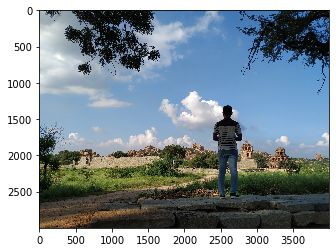

In [27]:
img = cv2.imread('./input_images/yash.jpg')
plt.imshow(img[:,:,::-1])
img = img[:,:,::-1]

In [28]:
# print(time.time())
bestVideos = findBestVideo(img)
# print(time.time())

1 / 463 	 30.971125 	 ../videos_h264/04_16_2012_16_36_28.mp4
2 / 463 	 33.186325 	 ../videos_h264/TimeLapseofSunsetHDRFX_7.mp4
3 / 463 	 33.195137 	 ../videos_h264/city.mp4
4 / 463 	 31.788517 	 ../videos_h264/Fort_Lauderdale_Time_lapse.mp4
5 / 463 	 32.324257 	 ../videos_h264/4006_2.mp4
6 / 463 	 32.594273 	 ../videos_h264/24__Hr_Time_Lapse.mp4
7 / 463 	 32.287167 	 ../videos_h264/Timelapse___Puerto_de_Malaga.mp4
8 / 463 	 28.829622 	 ../videos_h264/59399399.mp4
9 / 463 	 32.423172 	 ../videos_h264/24_Hour_Boston_Timelapse__Longwood_Medical_Area_.mp4
10 / 463 	 33.027874 	 ../videos_h264/cape_town_moonrise_time_lapse_1280x720.mp4
11 / 463 	 34.871258 	 ../videos_h264/80496929.mp4
12 / 463 	 31.331474 	 ../videos_h264/Sunset_over_the_Dubai_skyline_timelapse_HD_1080p.mp4
13 / 463 	 30.601686 	 ../videos_h264/40025.mp4
14 / 463 	 38.893494 	 ../videos_h264/Good_Morning_Hong_Kong_from_another_angle.mp4
15 / 463 	 33.195404 	 ../videos_h264/83485476.mp4
16 / 463 	 37.139038 	 ../videos_h26

267 / 463 	 35.13701 	 ../videos_h264/39616613.mp4
268 / 463 	 31.731716 	 ../videos_h264/4008_11.mp4
269 / 463 	 28.584702 	 ../videos_h264/Time_Lapse_Test_01_on_Vimeo.mp4
270 / 463 	 30.784779 	 ../videos_h264/Sunset_time_lapse_Gopro_Hero3_Black.mp4
271 / 463 	 30.316404 	 ../videos_h264/Downtown_Toronto_Timelapse_2.mp4
272 / 463 	 44.919876 	 ../videos_h264/Time_Lapse_Experiment_.mp4
273 / 463 	 34.74916 	 ../videos_h264/835.mp4
274 / 463 	 30.69502 	 ../videos_h264/Palma_de_Mallorca_s_Bay__a_24_hour_Timelapse.mp4
275 / 463 	 30.282726 	 ../videos_h264/04_16_2012_16_10_29.mp4
276 / 463 	 29.568485 	 ../videos_h264/Manhattan_Derecho_2012_07_26.mp4
277 / 463 	 29.743713 	 ../videos_h264/SandyTL_Time_Lapse_of_Sandy_Hitting_NYC.mp4
278 / 463 	 31.105207 	 ../videos_h264/NYC_TL_SHOT_1.mp4
279 / 463 	 32.441166 	 ../videos_h264/24_hours_time_lapse.mp4
280 / 463 	 31.055073 	 ../videos_h264/Time_lapse___24_hours_from_the_apartment__2_.mp4
281 / 463 	 35.343937 	 ../videos_h264/First_time_l

In [29]:
print(bestVideos)

[(27.783764, '../videos_h264/04_16_2012_15_58_53.mp4'), (28.148367, '../videos_h264/40291.mp4'), (28.236145, '../videos_h264/4006_1.mp4'), (28.2907, '../videos_h264/Gundog.mp4'), (28.364979, '../videos_h264/85037248_7b0ee676c5_orig.mp4')]


In [30]:
for i in bestVideos:
    print(i[0],i[1])
    cap = videoReader(i[1],play=True)

27.783764 ../videos_h264/04_16_2012_15_58_53.mp4
28.148367 ../videos_h264/40291.mp4
28.236145 ../videos_h264/4006_1.mp4
28.2907 ../videos_h264/Gundog.mp4
28.364979 ../videos_h264/85037248_7b0ee676c5_orig.mp4


In [22]:
cap = videoReader(bestVideos[1][1])
numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(numberOfFrames,width,height)

2438 1280 720


In [23]:
cap = videoReader(bestVideos[1][1],True)